# Calibrating LASER-based Models with Optuna and Coiled

In this notebook, we'll show you how to calibrate a LASER-based model using [Optuna](https://optuna.org/), and scaling the calibration to the cloud using [Coiled](https://www.coiled.io/).

The information from the notebook was derived form the following sources:
- [Coiled Hyperparameter Optimization w/Optuna Example](https://docs.coiled.io/user_guide/hpo.html)
- [Detailed Coiled+Optuna Examples](https://docs.coiled.io/user_guide/xgboost-hpo.html)
- [GitHub Repository for Coiled+Optuna Examples](https://github.com/coiled/dask-xgboost-nyctaxi)
- [Starsim Coiled Exmplration](https://github.com/starsimhub/starsim_compute_scaling/tree/main/platforms)
- [Katherine's Ax Example](https://github.com/krosenfeld-IDM/sandbox-botorch/blob/main/laser/london/run_service.py)

### 1. Set up the cluster

In [23]:
import coiled

cluster = coiled.Cluster(n_workers=20, name="laser-coiled-optuna")
client = cluster.get_client()

[2025-03-18 12:06:38,472][INFO    ][coiled] Fetching latest package priorities...
[2025-03-18 12:06:38,473][INFO    ][coiled.package_sync] Resolving your local .venv Python environment...
[2025-03-18 12:06:38,781][INFO    ][coiled.package_sync] Scanning 121 python packages...
[2025-03-18 12:06:40,134][INFO    ][coiled] Running pip check...
[2025-03-18 12:06:42,831][INFO    ][coiled] Validating environment...
[2025-03-18 12:06:45,035][INFO    ][coiled] Creating wheel for laser-coiled...
[2025-03-18 12:06:45,054][INFO    ][coiled] Uploading laser-coiled...
[2025-03-18 12:06:45,924][INFO    ][coiled] Requesting package sync build...
[2025-03-18 12:06:46,673][INFO    ][coiled] Creating Cluster (name: laser-coiled-optuna, https://cloud.coiled.io/clusters/800709 ). This usually takes 1-2 minutes...


### 2. Set up the study

In [24]:
import optuna

backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage)

study = optuna.create_study(
    direction="maximize",
    storage=dask_storage,  # This makes the study Dask-enabled
    sampler=optuna.samplers.RandomSampler(),
)

/var/folders/53/rsd5v8qj7_55jhks1nf8xwmc0000gn/T/ipykernel_91783/692952978.py:4: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage)


In [25]:
def objective(trial):
    # The objective function should include the following steps:
    # 1. extract trial parameters from the trial object
    # 2. run the simulation with the trial parameters
    # 3. return the simulation score

    return 1

### 3. Run the optimization in parallel

In [26]:
%%time

from dask.distributed import wait

futures = [
    client.submit(study.optimize, objective, n_trials=1, pure=False) for _ in range(500)
]

_ = wait(futures)

CPU times: user 421 ms, sys: 53 ms, total: 474 ms
Wall time: 2.21 s


### 4. Evaluate the results

In [27]:
print(study.best_params)
print(study.best_value)

{}
1.0


/var/folders/53/rsd5v8qj7_55jhks1nf8xwmc0000gn/T/ipykernel_91783/1412238616.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study);


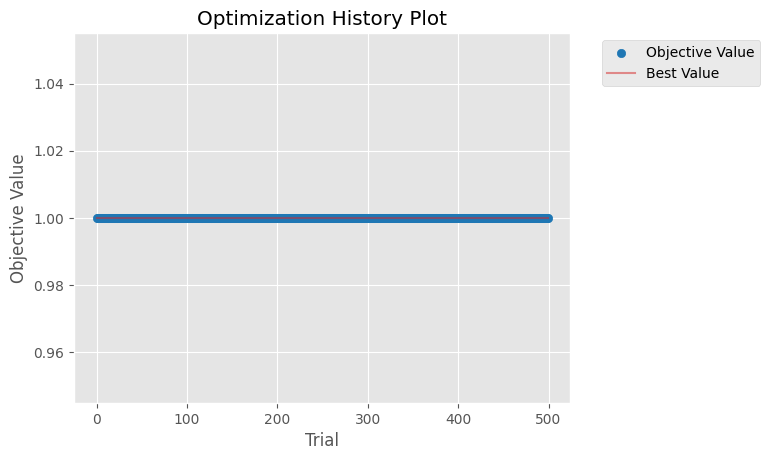

In [28]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

### 5. Clean up

In [30]:
cluster.shutdown()

[2025-03-18 12:08:56,496][INFO    ][coiled] Cluster 800709 deleted successfully.
